In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Regression Example

In [86]:
np.random.seed(42)
n_samples = 1_000_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + ( x2 - 6 ) ** 3 + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [87]:
x1_trans = FlatRampTransformer(
    knots = [1, 2, 3],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [5, 6, 7],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [88]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [89]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [90]:
from quantbullet.optimizer import LinearProductRegressionModelOLS

lprm_ols = LinearProductRegressionModelOLS()

In [91]:
lprm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, MSE: 1.1876
Iteration 2/10, MSE: 1.2209
Iteration 3/10, MSE: 1.2209
Iteration 4/10, MSE: 1.2209
Iteration 5/10, MSE: 1.2209
Iteration 6/10, MSE: 1.2209
Early stopping at iteration 6 with MSE: 1.2209


In [92]:
df['model_predict'] = lprm_ols.predict(train_df)

In [93]:
lprm_ols.coef_dict

{'x1': {'x1_bias': np.float64(0.1486338744788374),
  'x1_le_1': np.float64(-0.11971629019625457),
  'x1_1_2': np.float64(-0.040233324239199376),
  'x1_2_3': np.float64(0.03978549917146354),
  'x1_gt_3': np.float64(0.12035343273184522)},
 'x2': {'x2_bias': np.float64(-166.8112006814204),
  'x2_le_5': np.float64(14.967859972551514),
  'x2_5_6': np.float64(1.044326574809121),
  'x2_6_7': np.float64(1.0758261807408243),
  'x2_gt_7': np.float64(14.926530726325659)}}

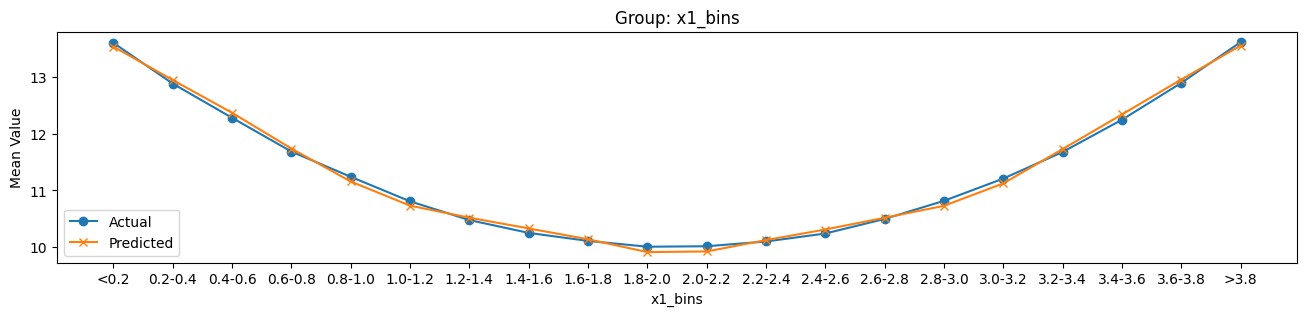

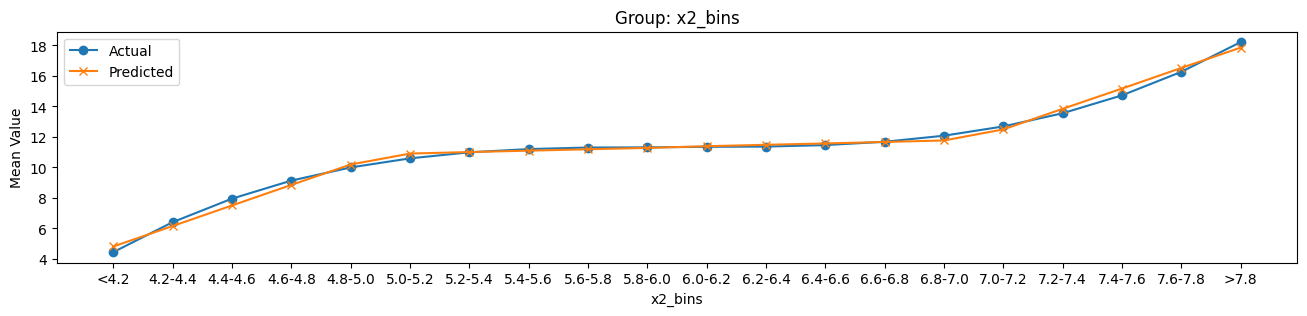

In [94]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example

In [95]:
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)

In [96]:
from quantbullet.optimizer import LinearProductRegressionModelOLS, LinearProductRegressionModelScipy

lprm_ols = LinearProductRegressionModelOLS()

In [97]:
lprm_ols.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10 )

Iteration 1/10, MSE: 0.0826
Iteration 2/10, MSE: 0.5061
Iteration 3/10, MSE: 4.5340
Iteration 4/10, MSE: 0.1441
Iteration 5/10, MSE: 0.2731
Iteration 6/10, MSE: 0.8667
Iteration 7/10, MSE: 9.0840
Iteration 8/10, MSE: 0.1995
Iteration 9/10, MSE: 0.0992
Iteration 10/10, MSE: 1.8275


In [98]:
df['model_predict_BCD'] = lprm_ols.predict(train_df)

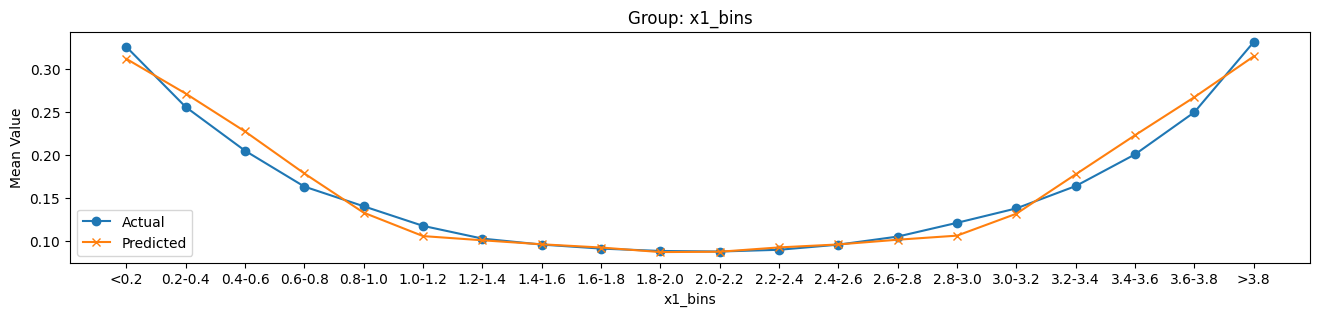

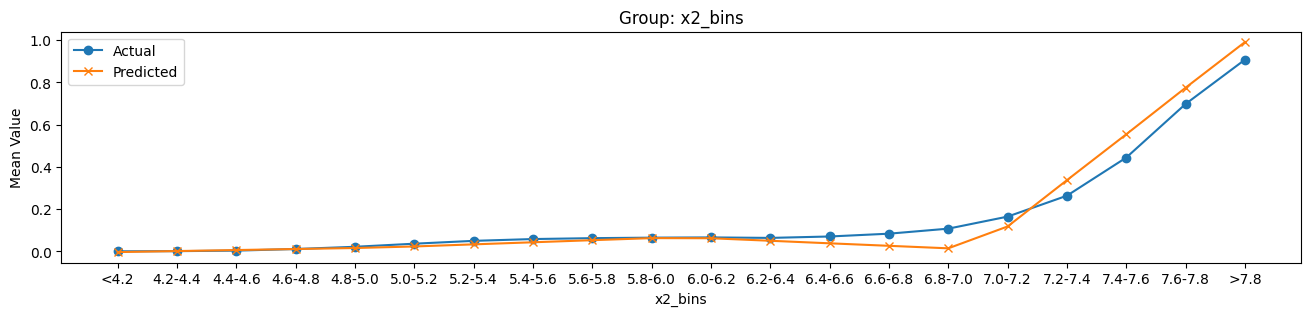

In [99]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [100]:
lprm_scipy = LinearProductRegressionModelScipy( xtol=1e-12, ftol=1e-12, gtol=1e-12 )
lprm_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=2, use_jacobian=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5750e+10                                    1.77e+10    
       1              2         6.1303e+09      1.96e+10       3.16e+00       1.18e+10    
       2              4         9.5543e+07      6.03e+09       1.58e+00       1.25e+09    
       3              5         2.7312e+06      9.28e+07       3.16e+00       4.20e+07    
       4              8         1.6227e+05      2.57e+06       3.95e-01       1.55e+06    
       5             10         8.4722e+04      7.76e+04       1.98e-01       7.21e+05    
       6             12         5.1848e+04      3.29e+04       4.94e-02       7.76e+04    
       7             13         5.1574e+04      2.74e+02       9.88e-02       4.36e+05    
       8             14         4.6847e+04      4.73e+03       2.47e-02       9.33e+03    
       9             15         4.6139e+04      7.07e+02       4.94e-02       1.29e+04    

In [84]:
df['model_predict'] = lprm_scipy.predict(train_df)

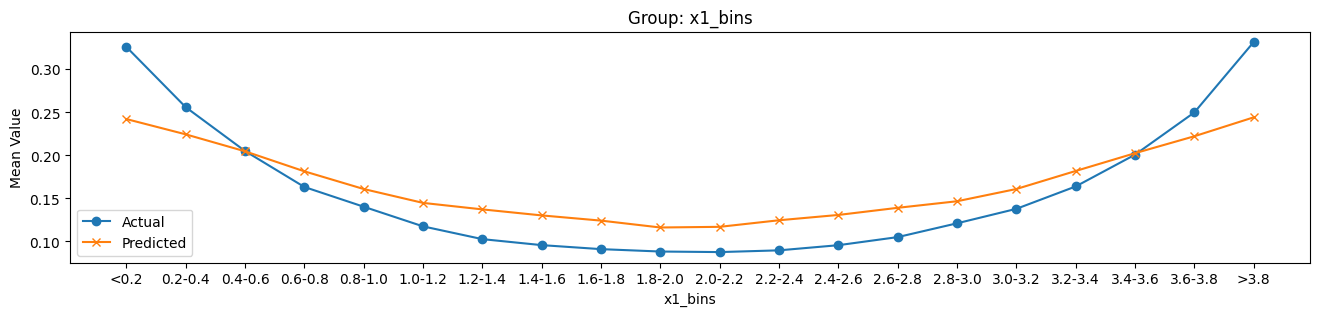

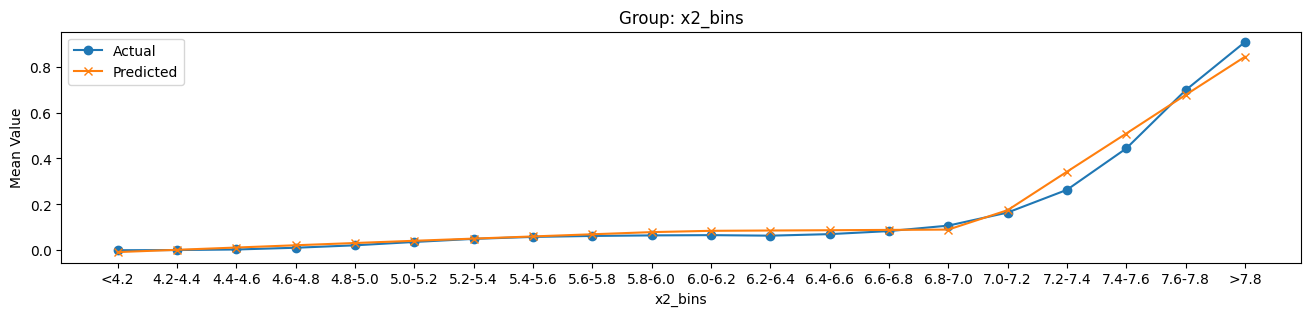

In [85]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()